# Рекомендация тарифов

Многие клиенты оператора мобильной связи «Мегалайн» пользуются архивными тарифами. Компания планирует построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

Есть данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных уже проведена.

Необходимо построить модель с максимально большим значением *accuracy*, не менее 0,75.

**Описание данных**

    Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 
    Известно:
    
    сalls — количество звонков
    minutes — суммарная длительность звонков в минутах
    messages — количество sms-сообщений
    mb_used — израсходованный интернет-трафик в Мб
    is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0)

**План проекта**

    1. Исходные данные, общая информация
    2. Выделение трех выборок
    3. Исследование модели
    4. Оценка моделей на тестовой выборке
    5. Проверка моделей на адекватность
    Заключение

## 1. Исходные данные, общая информация

In [1]:
import pandas as pd
import warnings
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
%config InlineBackend.figure_format='retina'
warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv('/datasets/users_behavior.csv')
display(data.head(5))
data.info()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [3]:
data.describe().round()

,calls,minutes,messages,mb_used,is_ultra
count,3214.0,3214.0,3214.0,3214.0,3214.0
mean,63.0,438.0,38.0,17208.0,0.0
std,33.0,235.0,36.0,7571.0,0.0
min,0.0,0.0,0.0,0.0,0.0
25%,40.0,275.0,9.0,12492.0,0.0
50%,62.0,431.0,30.0,16943.0,0.0
75%,82.0,572.0,57.0,21425.0,1.0
max,244.0,1632.0,224.0,49746.0,1.0


In [4]:
data.duplicated().sum()

0

In [5]:
data[data.is_ultra == 1].shape

(985, 5)

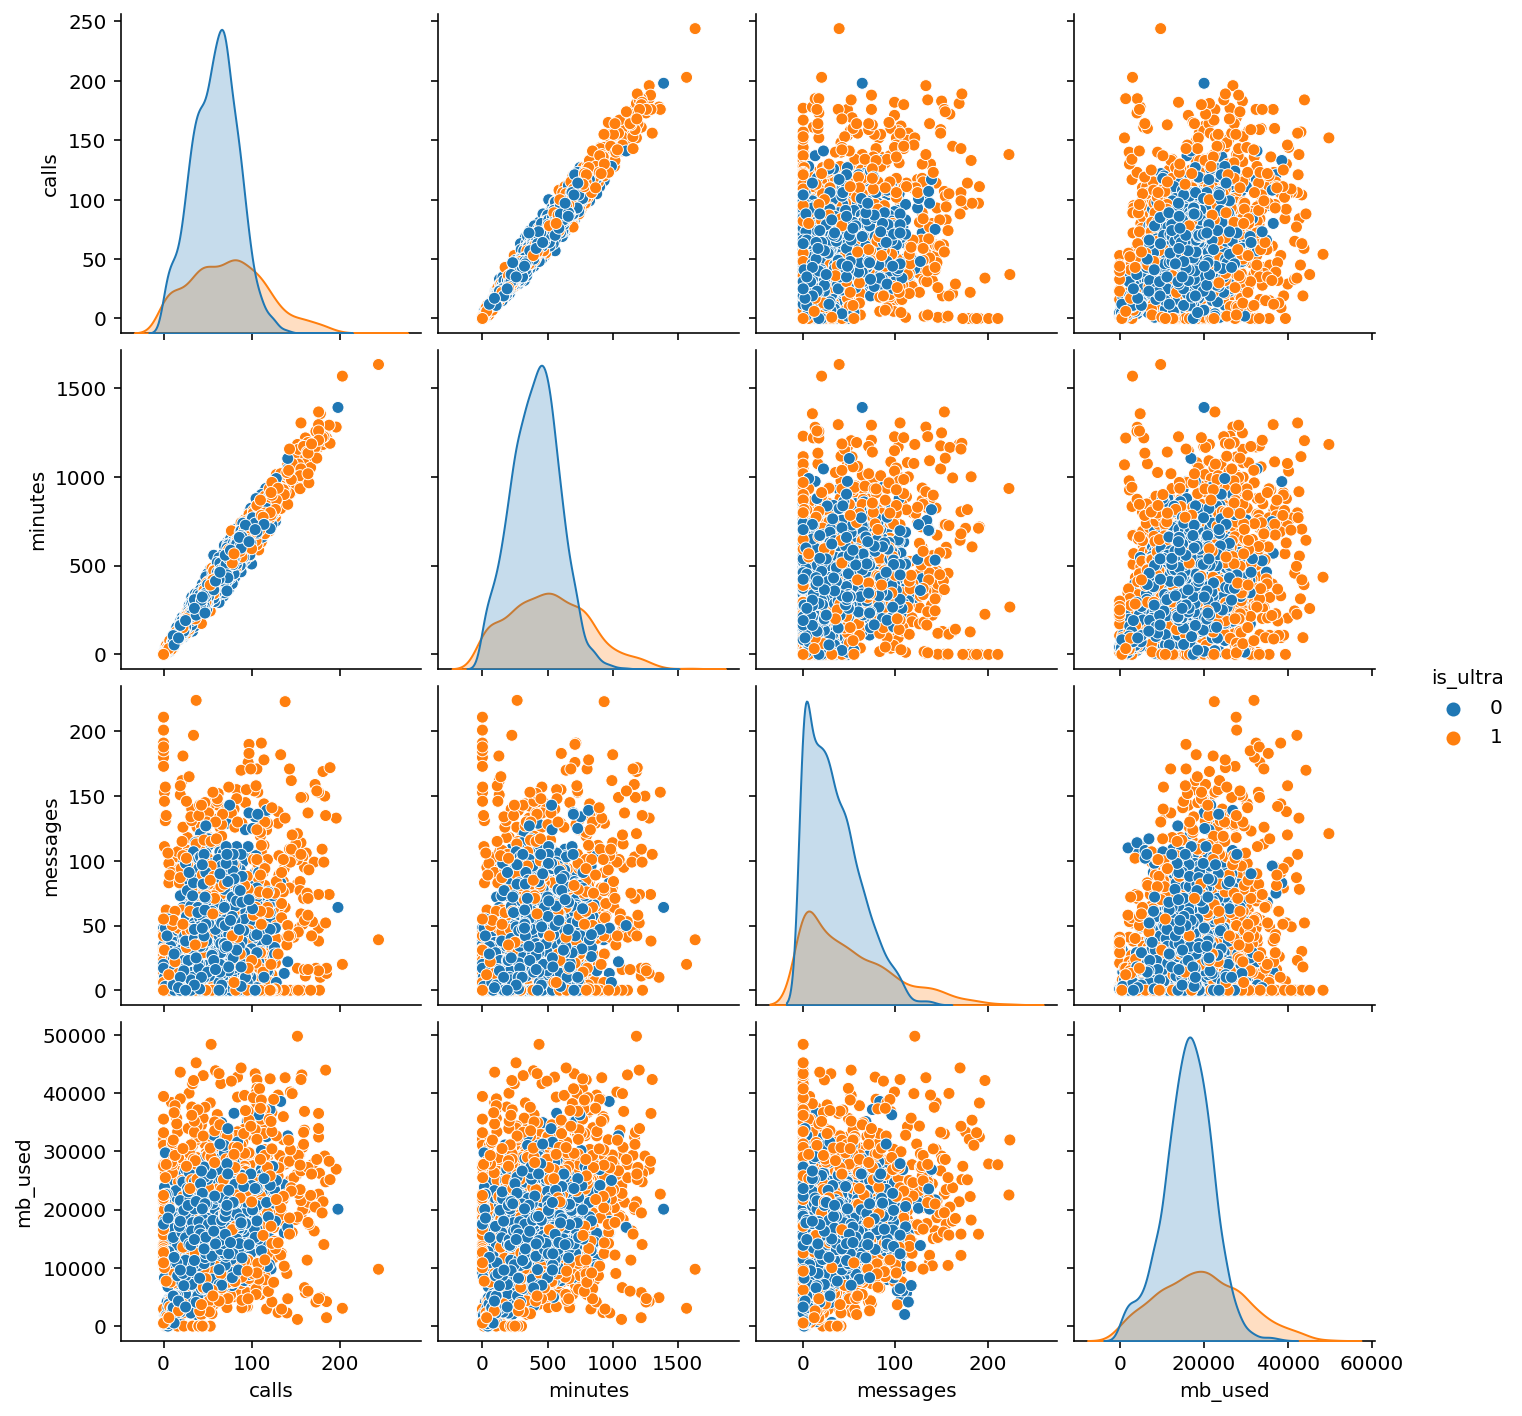

In [6]:
sns.pairplot(data, hue='is_ultra')

In [7]:
data.corr().round(3)

,calls,minutes,messages,mb_used,is_ultra
calls,1.000,0.982,0.177,0.286,0.207
minutes,0.982,1.000,0.173,0.281,0.207
messages,0.177,0.173,1.000,0.196,0.204
mb_used,0.286,0.281,0.196,1.000,0.199
is_ultra,0.207,0.207,0.204,0.199,1.000


Присутствует сильная корреляция признаков calls и minutes. Исключим один из признаков для построения моделей

In [8]:
data = data.drop('minutes', axis=1)

Исходный массив содержит 3214 записей по 5 признакам, дубликаты отсутствуют

## 2. Выделение трех выборок

Разобъем исходный массив на 3 выборки - тренировочную, валидационную и тестовую в пропорции 3:1:1

In [9]:
train, test = train_test_split(data, test_size=0.4, random_state=12345)

features_train = train.drop('is_ultra', axis=1)
target_train = train['is_ultra']

features_1 = test.drop('is_ultra', axis=1)
target_1 = test['is_ultra']

features_val, features_test, target_val, target_test = train_test_split(features_1, target_1, test_size=0.5,random_state=12345)

features_train = train.drop('is_ultra', axis=1)
target_train = train['is_ultra']

In [10]:
pd.DataFrame({'sample':['train', 'val', 'test'], 
              'feature_size':[features_train.shape, features_val.shape, features_test.shape], 
              'target_size':[target_train.shape, target_val.shape, target_test.shape]})

,sample,feature_size,target_size
0,train,"(1928, 3)","(1928,)"
1,val,"(643, 3)","(643,)"
2,test,"(643, 3)","(643,)"


## 3. Исследование моделей

**Дерево решений**

In [11]:
best_accuracy = 0
best_depth = 0
for depth in range(1,21):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    accuracy = model.score(features_val, target_val)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_depth = depth
        
print('Глубина дерева:', best_depth)
print('Качество:', round(best_accuracy, 4))

Глубина дерева: 5
Качество: 0.79


**Логистическая регрессия**

In [12]:
model = LogisticRegression()
model.fit(features_train, target_train)
accuracy = model.score(features_val, target_val)

print("Качество:", round(accuracy, 4))

Качество: 0.7076


**Случайный лес**

In [13]:
rfc = RandomForestClassifier(random_state=12345, n_jobs = -1)

parametrs = { 'n_estimators': range (5, 50, 5),
              'max_depth': range (1, 10),
              'min_samples_leaf': range (2,10)}

grid = GridSearchCV(rfc, parametrs)
grid.fit(features_train, target_train)

grid.best_params_

{'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 35}

In [14]:
model = RandomForestClassifier(max_depth=grid.best_params_['max_depth'], 
                               n_estimators=grid.best_params_['n_estimators'], 
                               min_samples_leaf=grid.best_params_['min_samples_leaf'], 
                               random_state=12345)
model.fit(features_train, target_train)
acc = model.score(features_val, target_val)
round(acc, 4)

0.79

## 4. Оценка моделей на тестовой выборке

Для обучения модели рассмотрим вариант выборки train+val и train

In [15]:
f = pd.concat([features_train, features_val], axis=0)
t = pd.concat([target_train, target_val], axis=0)
print(f.shape)
print(t.shape)

(2571, 3)
(2571,)


In [16]:
model = DecisionTreeClassifier(max_depth=8, random_state=12345)
model.fit(f, t)
accuracy_1 = model.score(features_test, target_test)

model = LogisticRegression()
model.fit(f, t)
accuracy_2 = model.score(features_test, target_test)

model = RandomForestClassifier(max_depth=9, n_estimators=35, min_samples_leaf=3, random_state=12345)
model.fit(f, t)
accuracy_3 = model.score(features_test, target_test)

print('Дерево решений. Качество:', round(accuracy_1, 4))
print('Логистическая регрессия. Качество:', round(accuracy_2,4))
print('Случайный лес. Качество:', round(accuracy_3,4))      

Дерево решений. Качество: 0.7776
Логистическая регрессия. Качество: 0.7434
Случайный лес. Качество: 0.804


In [17]:
print(features_train.shape)
print(target_train.shape)

(1928, 3)
(1928,)


In [18]:
model = DecisionTreeClassifier(max_depth=8, random_state=12345)
model.fit(features_train, target_train)
accuracy_1 = model.score(features_test, target_test)

model = LogisticRegression()
model.fit(features_train, target_train)
accuracy_2 = model.score(features_test, target_test)

model = RandomForestClassifier(max_depth=9, n_estimators=35, min_samples_leaf=3, random_state=12345)
model.fit(features_train, target_train)
accuracy_3 = model.score(features_test, target_test)

print('Дерево решений. Качество:', round(accuracy_1, 4))
print('Логистическая регрессия. Качество:', round(accuracy_2,4))
print('Случайный лес. Качество:', round(accuracy_3,4))    

Дерево решений. Качество: 0.7885
Логистическая регрессия. Качество: 0.6936
Случайный лес. Качество: 0.7963


Наилучшее качество достигается при использовании RandomForestClassifier с гиперпараметрами max_depth=9 , n_estimators=35 , min_samples_leaf=3

### 5. Проверка моделей на адекватность

Сравним качество выбранной модели с качеством случайного прогноза

In [19]:
d_ = DummyClassifier(strategy='most_frequent', random_state=12345)
d_.fit(features_train, target_train)
a_ = d_.score(features_test, target_test)

In [20]:
print('accuracy', round(a_, 4))

accuracy 0.6843


Качество выбранной модели RandomForestClassifier выше случайных прогнозов

## Заключение

Рассмотрено 3 модели, лучшее качество дает RandomForestClassifier с гиперпараметрами max_depth=9 , n_estimators=35, min_samples_leaf=3. Точность модели составляет более 0,79 на тестовой выборке, что выше требуемого параметра 0,75.